In [71]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from tensorflow import keras

from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

import gc

print("Loading Libraries Done")

Loading Libraries Done


In [72]:
main_folder ="D:\\Neeru\\Python & DataScience\\Live projects\\RP_Project\\RP_dataset"

categories = os.listdir(main_folder)
# try:
#     categories.remove(".DS_Store")
# except:
#     pass
print(categories, len(categories))

['Normal', 'RP'] 2


In [73]:
import os
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import cv2

IMAGE_SIZE = (128, 128, 3)

def image_preprocessing_with_balanced_augmentation(main_folder, categories):
    img_lst = []
    labels = []

    image_counts = defaultdict(int)
    image_paths_by_class = defaultdict(list)

    # Step 1: Collect image paths
    for index, category in enumerate(categories):
        folder_path = os.path.join(main_folder, category)
        for image_name in os.listdir(folder_path):
            file_ext = image_name.split(".")[-1].lower()
            if file_ext in ["jpg", "jpeg", "png", "bmp"]:
                image_counts[index] += 1
                image_paths_by_class[index].append(os.path.join(folder_path, image_name))

    max_count = max(image_counts.values())  # 2676 in your case

    # Step 2: Load images and augment only the minority class
    for index, category in enumerate(categories):
        print(f"Processing category: {category}")

        current_images = image_paths_by_class[index]
        total_original = len(current_images)
        augment_needed = max_count - total_original
        augmented_count = 0

        for image_path in tqdm(current_images):
            try:
                img = cv2.imread(image_path)
                img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Add original image
                img_lst.append(np.array(img))
                labels.append(index)

                # Augment only the minority class
                if augment_needed > 0 and augmented_count < augment_needed:
                    for aug_img in [cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE),
                                    cv2.flip(img, 1),
                                    cv2.flip(img, 0)]:
                        if augmented_count >= augment_needed:
                            break
                        img_lst.append(np.array(aug_img))
                        labels.append(index)
                        augmented_count += 1

            except Exception as e:
                print("Error with image:", image_path, e)

        # ✅ Debug print for RP class
        if category == "RP":
            print(f"Augmented RP image count: {augmented_count}")

    # Step 3: Convert to numpy arrays
    images = np.array(img_lst, dtype=np.float16) / 255.0
    labels = np.array(labels, dtype=np.int8)
    return images, labels


In [74]:
images, labels = image_preprocessing_with_balanced_augmentation(main_folder, categories)
print("Balanced dataset shape:", images.shape, labels.shape)

Processing category: Normal


100%|██████████| 2676/2676 [01:28<00:00, 30.17it/s]


Processing category: RP


100%|██████████| 834/834 [00:24<00:00, 34.04it/s]


Augmented RP image count: 1842
Balanced dataset shape: (5352, 128, 128, 3) (5352,)


In [75]:
# First split into train+val and test
x_temp, x_test, y_temp, y_test = train_test_split(images, labels, test_size=0.1, random_state=6)

# Then split x_temp into train and val
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.1, random_state=6)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


x_train shape: (4334, 128, 128, 3)
y_train shape: (4334,)
x_val shape: (482, 128, 128, 3)
y_val shape: (482,)
x_test shape: (536, 128, 128, 3)
y_test shape: (536,)


In [76]:
# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)  # If you want to evaluate/test later


In [77]:
del labels
del images

In [78]:
EPOCHS = 10
BATCH_SIZE = 16

### VGG

In [79]:
vgg = VGG19(input_shape=IMAGE_SIZE , weights='imagenet', include_top=False)

In [80]:
#do not train the pre-trained layers of VGG-19
for layer in vgg.layers:
    layer.trainable = False

In [81]:
TOTAL_CATEGORIES = len(categories)
x = Flatten()(vgg.output)
#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(TOTAL_CATEGORIES, activation='softmax')(x)
vgg_model = Model(inputs=vgg.input, outputs=prediction)
vgg_model.summary()# view the structure of the model

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │        16,386 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,040,770 (76.45 MB)

 Trainable params: 16,386 (64.01 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [82]:
vgg_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [83]:
#Early stopping to avoid overfitting of model
early_stop = EarlyStopping(
    monitor='val_accuracy', 
    patience=3, 
    restore_best_weights=True,
    verbose=1
)


### Model Training

In [84]:
# fit the model
history = vgg_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    shuffle=True
)

# history = model.fit(x_train, y_train, 
#                             validation_data=(x_test, y_test), 
#                             steps_per_epoch = 10, epochs=EPOCHS, callbacks=[early_stop], 
#                             batch_size=BATCH_SIZE, 
#                             validation_steps = y_test.shape[0]//BATCH_SIZE, shuffle=True)

Epoch 1/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 247s 905ms/step - accuracy: 0.8724 - loss: 0.3122 - val_accuracy: 0.9772 - val_loss: 0.0936
Epoch 2/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 212s 781ms/step - accuracy: 0.9726 - loss: 0.1065 - val_accuracy: 0.9772 - val_loss: 0.0668
Epoch 3/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 217s 801ms/step - accuracy: 0.9813 - loss: 0.0724 - val_accuracy: 0.9855 - val_loss: 0.0597
Epoch 4/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 247s 911ms/step - accuracy: 0.9764 - loss: 0.0697 - val_accuracy: 0.9896 - val_loss: 0.0501
Epoch 5/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 230s 851ms/step - accuracy: 0.9815 - loss: 0.0568 - val_accuracy: 0.9876 - val_loss: 0.0446
Epoch 6/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 239s 880ms/step - accuracy: 0.9824 - loss: 0.0529 - val_accuracy: 0.9834 - val_loss: 0.0478
Epoch 7/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 227s 839ms/step - accuracy: 0.9846 - loss: 0.0441 - val_accuracy: 0.9813 - val_loss: 0.0643
Epoch 7: early stopping
Restoring model weights from the end of the best epo

In [85]:
tf.keras.backend.clear_session()
loss, acc = vgg_model.evaluate(x_test,y_test,batch_size=32)
print("vgg Loss:", loss)
print("vgg Accuracy:", acc*100, "%")

17/17 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9778 - loss: 0.0515
vgg Loss: 0.05790341645479202
vgg Accuracy: 97.76119589805603 %


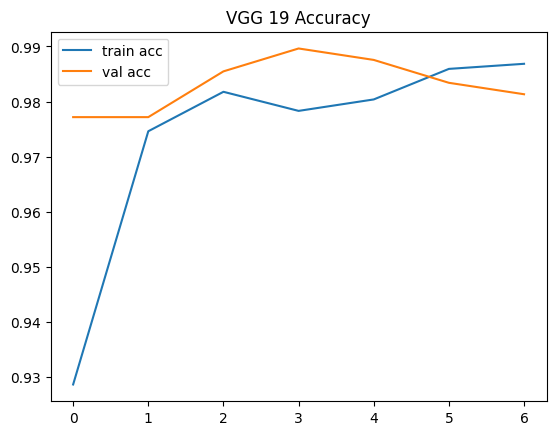

In [86]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title("VGG 19 Accuracy")
plt.legend()
plt.show()

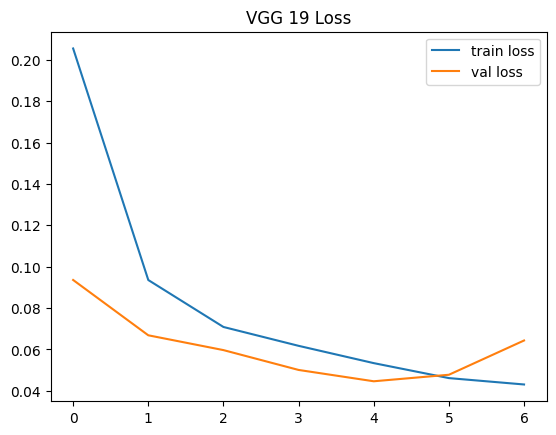

In [87]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title("VGG 19 Loss")
plt.legend()
plt.show()

In [88]:
print(f"y_test_flat shape: {y_test_flat.shape}")
print(f"y_pred shape: {y_pred.shape}")


y_test_flat shape: (536,)
y_pred shape: (536,)


In [89]:


# 1. Predict raw output
y_pred_raw = vgg_model.predict(x_test)

# 2. If shape is (536, 2), convert to predicted class using argmax
if y_pred_raw.shape[1] == 2:
    y_pred = np.argmax(y_pred_raw, axis=1)
else:
    # Otherwise, it's (536, 1) – just threshold it
    y_pred = (y_pred_raw > 0.5).astype("int32").flatten()

# 3. Convert y_test if it's one-hot encoded
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test_flat = y_test.argmax(axis=1)
else:
    y_test_flat = y_test.flatten()

# 4. Confirm shapes now match
print(f"y_test_flat shape: {y_test_flat.shape}, y_pred shape: {y_pred.shape}")

# 5. Evaluation
print("Classification Report:")
print(classification_report(y_test_flat, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test_flat, y_pred))


17/17 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step
y_test_flat shape: (536,), y_pred shape: (536,)
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       268
           1       0.98      0.97      0.98       268

    accuracy                           0.98       536
   macro avg       0.98      0.98      0.98       536
weighted avg       0.98      0.98      0.98       536

Confusion Matrix:
[[264   4]
 [  8 260]]


In [90]:
# Save the model
vgg_model.save("RP_detection_model.h5", save_format="h5")
